# Over-fitting and Under-fitting
Underfitting is when a model can still be improved, becuase it's not powerful enough for the situtation, it's over-regularized (over simplified), or maybe it's just not been trained enough. Overfitting on the other hand is when the model starts to memorize the training data and draw patterns that don't (or aren't supposed to) apply to the test data. You have to strike a balance.

In [1]:
import tensorflow as tf
print(tf.__version__)
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

2.8.0


In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

### Higgs dataset
Just a dataset. Using tf's build in function to grab this dataset for us. It contains 11,000,000 examples, each with 28 features, and a binary class label.

In [3]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')
FEATURES = 28

This Tf function allows the dataset to be read without first having to be decompressed

In [4]:
ds = tf.data.experimental.CsvDataset(gz,[float()]*(FEATURES+1), compression_type="GZIP")

2022-05-13 20:56:55.500152: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [5]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

I guess TF is optimized to work with large datasets, so the best way to repack this function is to take them in batches of 10,000 from the dataset instead of one at a time

In [6]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


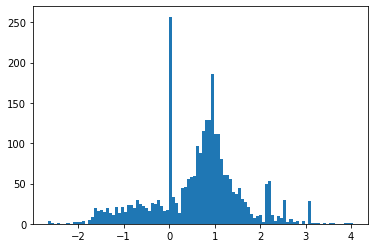

In [7]:
#took like 9 minutes to run. don't run
for f, l in packed_ds.batch(100).take(1):
    print(f[0])
    plt.hist(f.numpy().flatten(), bins = 101)

While there's much more data, we're only going to use the first 1k for validation and the next 10k for training. 

In [9]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

Using tensorflow's take, skip, and cache functions on the dataset

In [10]:
val_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

Currently both the val_ds and train_ds are going to contain individual values, but we want them batched. Or rather, tensorflow wants them batched. Because the train data might be in some sort of order, we're going to shuffle it before batching.

In [11]:
val_ds = val_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)